## Q4 

The goal of the Q4 is to build a light and explainable classifier to predict the **cell layer** of **excitatory neurons** during **free whisking** trials.
Specifically, in this notebook we will:
- import the dataset
- Compute the part 1 features (free whisking BUT only *quite* features)
- Compute the part 2 features (free whisking BUT only *whisking* features)
- Compute other features from the Vm time series of the cells

In the end, the final dataset will have as samples each unique cell, with part 1, part 2 and new features, and we will try to assess their importance in predicting the cell layer.

In [1]:
#import libraries

import os
import sys
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

#### Importing helper functions
 Feel free to check out what these functions do in the corresponding files, `helpers.py` or `utils.py`. 
 - `helpers.py` contains functions to analyze membrane potential recording data
 - `utils.py` contains functions useful for other things e.g. plotting

In [2]:
base_path = os.getcwd()
base_path = base_path.replace('notebooks', 'scripts') # note: if you have notebooks twice in your base_path, this won't work
sys.path.insert(1, base_path)

from helpers import *
from utils import remove_top_right_frame, jitter_scatterplot

# Load data
Load previously saved dataframe as `.csv` file:

In [3]:
# Make paths
main_dir = r'C:\Users\Utente\Documents\neuro_circ\BIO482_MiniProject_2025_Python\BIO482_MiniProject_2025_Python' # EDIT the path !!!!!!!
print('Main working directory:', main_dir)
figure_path = os.path.join(main_dir, 'Figures')
os.makedirs(figure_path, exist_ok=True)
data_path = os.path.join(main_dir, 'Data') #if your folder is organized differently, just specify the full path to the .mat file
open(main_dir + "/test.txt", "w").write("test")

fname = 'data_bio482.pkl'
data_df = pd.read_pickle(os.path.join(data_path, fname))

Main working directory: C:\Users\Utente\Documents\neuro_circ\BIO482_MiniProject_2025_Python\BIO482_MiniProject_2025_Python


## PART 1 FEATURES

Use Part 1's functions to extract quiet-related features.

In [15]:
sweep_type = 'free whisking'
time_window = 2    # time window to analyze Vm (s)
freq_band_lim = [1, 10, 30, 90] # low- and high-frequency band limits (Hz)

data_df_subset = data_df[data_df['Sweep_Type']==sweep_type] 

In [16]:
# Analyse and plot one sweep for one neuron

cell_list = sorted(np.unique(data_df_subset.Cell_ID), reverse=True) #NOTE: DO NOT START WITH AC32 bc. no AP and undefined ap_params content

# choose 1 cell
cell=cell_list[182];

# Get data subset for that cell
cell_df = data_df_subset[data_df_subset.Cell_ID==cell]

# Get sweeps/trials recorded for that cell, that we are going to iterate over
trial_list = cell_df.Sweep_Counter.values
trial=trial_list[0]
# Get current trial data
cell_trial_df = cell_df[cell_df.Sweep_Counter==trial]

# Get the sampling rate and membrane potential (and derivative) from that sweep
        
sr_vm = cell_trial_df['Sweep_MembranePotential_SamplingRate'].values[0] #[0] to get the content of the array
membrane_potential = cell_trial_df['Sweep_MembranePotential'].values[0]
ap_vm_deriv_thresh = cell_trial_df['Cell_APThreshold_Slope'].values[0]
        
# Get and update recording duration for that cell by adding trial duration
trial_rec_duration = len(membrane_potential)/sr_vm
#tot_rec_duration += trial_rec_duration
        
# Detection of action potentials for that trial, and update total number of APs for that cell
#ap_params = None
ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh) 
#tot_number_ap += ap_params.shape[0]
          
# Check if this trial contains any AP...
ap_duration = []

if (ap_params.any()):
    ap_thresh_times = ap_params[:,0]
    ap_thresh_vm = ap_params[:,1]
    ap_peak_times = ap_params[:,2]
    ap_peak_vm = ap_params[:,3]
    ap_duration = ap_params[:,5] #check for no-APs (cells with no spikes in ALL trials:EXC5,16 FR=0, AP_dur=np.nan)

    #... if so, cut-out individual APs to keep subthreshold Vm only
    vm_sub = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)
            
     # Else if no AP, subthreshold Vm is just Vm
else:
            
         vm_sub = membrane_potential.copy()
            
# Optional plotting: show AP and AP peak times

time=[];
for i in range(0, len(membrane_potential)):
    time.append(i/sr_vm)

ap_peak_index=np.round(ap_peak_times * sr_vm)
ap_thresh_index=np.round(ap_thresh_times * sr_vm)

Now compute the first:

In [17]:
all_cells = np.unique(data_df_subset.Cell_ID)
verbose=False #set to 0 to hide individual AP plots

# Initialize a dictionary to store data for all cell
result_dict = {'cell_id': all_cells, 
          'cell_type':[], # required for cell-type identification
          # Data we'll collect for Part 1a
          'firing_rate': [], 
          'ap_threshold': [], 
          'ap_duration': [], 
          # Data we'll collect for Part 1b
          'mean_vm':[],
          'std_vm':[],
          'fft_low':[],
          'fft_high':[]
        }

result_fft_cell_type = {'EXC':[],'SST':[], 'VIP':[],'PV':[]}

exc_cell_counter = 0

# Iterate over each cell identities to collect desired data
cell_list = sorted(np.unique(data_df_subset.Cell_ID), reverse=True) #NOTE: DO NOT START WITH AC32 bc. no AP and undefined ap_params content
for idx, cell in enumerate(all_cells):
    if idx%100==0:
        print('Cell {}/{}'.format(idx, np.unique(data_df_subset.Cell_ID).shape[0]))
    
    # Get mouse name and cell number from cell identifier
    mouse = cell.split('_')[0]
    cell_count = float(cell.split('_')[1])
    
    # Get data subset for that cell
    cell_df = data_df_subset[data_df_subset.Cell_ID==cell]
    
    # Get cell type 
    cell_type = cell_df.Cell_Type.values[0]
    result_dict['cell_type'] += [cell_type]
    
    # Get sweeps/trials recorded for that cell, that we are going to iterate over
    trial_list = cell_df.Sweep_Counter.values
    
    # Init. cell recording specific quantities: a unique duration, yielding a unique number of APs
    tot_rec_duration = 0
    tot_number_ap = 0
    
    # Initialize empty lists to get data for each trial/sweep
    # Part 1a
    tot_ap_thresh = []
    tot_ap_duration = []
    # Part 1b
    tot_mean_vm = []
    tot_std_vm = []
    tot_fft = []
    
    # For that cell, iterate over trials
    for trial in trial_list:
        #if idx % 100 == 0: # print every 100 iteration  
            #print('Cell {},  trial {}'.format(cell, int(trial)))
        if cell_type == 'EXC':
            exc_cell_counter += 1
        
        # Get current trial data
        cell_trial_df = cell_df[cell_df.Sweep_Counter==trial]
        
        # Get the sampling rate and membrane potential (and derivative) from that sweep
        sr_vm = cell_trial_df['Sweep_MembranePotential_SamplingRate'].values[0] #[0] to get the content of the array
        membrane_potential = cell_trial_df['Sweep_MembranePotential'].values[0]
        ap_vm_deriv_thresh = cell_trial_df['Cell_APThreshold_Slope'].values[0]
        
        # Get and update recording duration for that cell by adding trial duration
        trial_rec_duration = len(membrane_potential)/sr_vm
        tot_rec_duration += trial_rec_duration
        
        # Detection of action potentials for that trial, and update total number of APs for that cell
        #ap_params = None
        ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh) 
        tot_number_ap += ap_params.shape[0]
          
        # Check if this trial contains any AP...
        ap_duration = []
        if (ap_params.any()):
            ap_thresh_times = ap_params[:,0]
            ap_thresh_vm = ap_params[:,1]
            ap_peak_times = ap_params[:,2]
            ap_peak_vm = ap_params[:,3]
            ap_duration = ap_params[:,5] #check for no-APs (cells with no spikes in ALL trials:EXC5,16 FR=0, AP_dur=np.nan)

            #... if so, cut-out individual APs to keep subthreshold Vm only
            vm_sub = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)
            
            
        # Else if no AP, subthreshold Vm is just Vm
        else:
            
            vm_sub = membrane_potential.copy()

        # Once Vm_sub is obtained:
        # Compute subthreshold Vm mean and standard deviation
        mean_vm, std_vm = Function_SubThrsVm(vm_sub, sr_vm, trial_rec_duration)
        
        # Compute trial FFT
        fft = Function_Compute_FFTs(vm_sub, sr_vm, time_window)
        
        #Update current variables from the current trial
        # Part 1a
        tot_ap_thresh += [np.concatenate([ap_thresh_vm])]
        tot_ap_duration += [ap_duration]
        # Part 1b
        tot_mean_vm += [mean_vm]
        tot_std_vm += [std_vm]
        tot_fft +=  [fft]
        
        # Optional plotting: show AP and AP peak times
        ap_peak_index=np.round(ap_peak_times * sr_vm)  
        if verbose:
            fig, ax = plt.subplots(1,1, figsize=(10,2), dpi=300)
            remove_top_right_frame(ax)
            ax.set_title('Cell {},  trial {}'.format(cell, int(trial)))
            ax.plot(membrane_potential, lw=0.5,  zorder=0)
            ax.scatter(ap_peak_index, ap_peak_vm, lw=0.5, marker='+', color='r')
            ax.set_xlabel('Time (samples)')
            ax.set_ylabel('Membrane \n potential (V)')
            plt.show()

    # Once iterated over all trials for that cell, append cell data lists to the result dictionary
  
    # Part 1a
    result_dict['firing_rate'] += [tot_number_ap / tot_rec_duration] # <- just the firing rate formula
    result_dict['ap_threshold'] += [np.nanmean(np.concatenate(tot_ap_thresh))] #<-concatenate trials, get trial-average
    result_dict['ap_duration'] += [np.nanmean(np.concatenate(tot_ap_duration))]

    
    # Part 1b
    result_dict['mean_vm'] += [np.nanmean(np.concatenate(tot_mean_vm))]
    result_dict['std_vm'] += [np.nanmean(np.concatenate(tot_std_vm))]
    
    # Compute mean FFT over trials
    tot_fft = np.nanmean(np.concatenate(tot_fft, axis=1), 1)
    #Store mean cell FFT
    result_fft_cell_type[cell_type] += [tot_fft] 
    
    # We need to find which point (sample) in the FFT correspond to which frequency
    pt1 = int(freq_band_lim[0] * fft.shape[0] / (sr_vm/2) ) + 1 #1Hz into FFT point
    pt2 = int(freq_band_lim[1] * fft.shape[0] / (sr_vm/2) ) + 1 #int: slicing requires integers
    result_dict['fft_low'] += [tot_fft[pt1:pt2].mean()]
    
    pt3 = int(freq_band_lim[2] * fft.shape[0] / (sr_vm/2) ) + 1
    pt4 = int(freq_band_lim[3] * fft.shape[0] / (sr_vm/2) ) + 1 
    result_dict['fft_high'] += [tot_fft[pt3:pt4].mean()]

## Convert each dictionary lists as numpy arrays (convenient to make dataframes)
result_dict = {key: np.array(result_dict[key]) for key in result_dict.keys()}

print('Done!')

Cell 0/232


c:\Users\Utente\Documents\GitHub\Circuit_and_mechanism_project25\helpers.py:55: RuntimeWarning: invalid value encountered in divide
  sAP_OnOff = np.diff(np.divide(sAP_Seg, np.abs(sAP_Seg)))  # compute the binary signal
C:\Users\Utente\AppData\Local\Temp\ipykernel_11380\700022463.py:130: RuntimeWarning: Mean of empty slice
  result_dict['ap_duration'] += [np.nanmean(np.concatenate(tot_ap_duration))]


Cell 100/232
Cell 200/232
Done!


In [18]:
result_df = pd.DataFrame(result_dict)
result_df.head(5)

,cell_id,cell_type,firing_rate,ap_threshold,ap_duration,mean_vm,std_vm,fft_low,fft_high
0,AP032_1,PV,29.116667,-0.044055,0.390398,-0.055180,0.004857,0.000641,0.000095
1,AP032_2,PV,18.750000,-0.040905,0.532933,-0.049470,0.005034,0.000654,0.000104
2,AP035_1,PV,20.500000,-0.044700,0.513374,-0.055808,0.006227,0.000842,0.000106
3,AP035_2,PV,33.460000,-0.042587,0.423192,-0.051303,0.006347,0.000867,0.000090
4,AP039_1,SST,0.400000,-0.042144,0.637500,-0.058334,0.002842,0.000338,0.000028


significative features:
- firing rate;
- ap_duration;
- mean_vm;

In [80]:
results_df_p1 = result_df.copy()
results_df_p1 = results_df_p1.drop(columns=['std_vm', 'fft_low', 'fft_high', 'ap_threshold'])
results_df_p1.to_pickle(os.path.join(data_path, 'features_part1.pkl'))

In [176]:
results_df_p1.head()

,cell_id,cell_type,firing_rate,ap_duration,mean_vm_part1
0,AP032_1,PV,29.116667,0.390398,-0.055180
1,AP032_2,PV,18.750000,0.532933,-0.049470
2,AP035_1,PV,20.500000,0.513374,-0.055808
3,AP035_2,PV,33.460000,0.423192,-0.051303
4,AP039_1,SST,0.400000,0.637500,-0.058334


In [175]:
results_df_p1.columns = ['cell_id', 'cell_type', 'firing_rate', 'ap_duration', 'mean_vm_part1']

## Part 2 features

Now we can use the features from part 2 (still sweep type set as free whisking, but now the analysis focuses on the whisking events rather than sub)

In [21]:
#get the constants of part 2

pre_window = 0.5 # time before whisking onset (s)
post_window = 0.5 # time after whisking onset (s)
min_event_dur = 0.2 # minimal duration of whisking episode to be considered
min_iti = 0.5 # minimal intertrial interval (ITI) between 2 consecutive whisking episode (s)
min_number_trials = 2 # minimal number of trial
bin_size = 0.05 # bin size for psth (s)
epoch_bounds = {'pre':[-0.5, -0.3],
                  'post':[0,0.2]}  # time boundaries to compute changes in whisker protraction (WP), or Vm

Get the features now

In [22]:
verbose=0 #set to 0 to hide individual AP plots

# Initialize a dictionary to store data for all cell
result_dict_w = {'cell_id': all_cells, 
          'cell_type':[], 
          # This is a template, an example with whisker protraction
          'numb_events': [],
          'wp_avg': [],
          'wp_amplitude_pre': [],
          'wp_amplitude_post': [],
          # Sub. Vm
          'vm_avg': [], 
          'vm_amplitude_pre': [],
          'vm_amplitude_post': [],
          # Firing rates
          'ap_avg':[],
          'ap_psth':[],
          'ap_fr_pre':[],
          'ap_fr_post':[]
        }
    
# Iterate over each cell identities to collect desired data
for idx, cell in enumerate(np.unique(data_df_subset.Cell_ID)):
    if idx%100==0:
        print('Cell {}/{}'.format(idx, np.unique(data_df_subset.Cell_ID).shape[0]))
    
    # Get mouse name and cell number from cell identifier
    mouse = cell.split('_')[0]
    cell_count = float(cell.split('_')[1])
    
    # Get data subset for that cell
    cell_df = data_df_subset[data_df_subset.Cell_ID==cell]
    
    # Get cell type 
    cell_type = cell_df.Cell_Type.values[0]
    result_dict_w['cell_type'] += [cell_type]
    
    # Get sweeps/trials recorded for that cell, that we are going to iterate over
    trial_list = cell_df.Sweep_Counter.values
    
    # Init. cell recording specific quantities: a unique duration, yielding a unique number of APs
    tot_rec_duration=0
    tot_number_ap=0
    
    # Initialize empty lists to get data for each trial/sweep
    tot_ap_thresh = []
    tot_ap_duration= []
    
    # Template
    tot_wp_events = []
    
    # Vm and AP FR
    tot_vm_events = []
    tot_ap_events = []
    
    ## For that cell, iterate over trials
    for trial in trial_list:
        
        # Get current trial data
        cell_trial_df = cell_df[cell_df.Sweep_Counter==trial]
        
        # Get event times for that trial
        event_times = cell_trial_df['Sweep_WhiskingTimes'].values[0]

        if event_times is None: # skip when there are no events
            continue
        
        # Get the sampling rate and membrane potential (and derivative) from that sweep
        sr_vm = cell_trial_df['Sweep_MembranePotential_SamplingRate'].values[0] #[0] to get the content of the array
        membrane_potential = cell_trial_df['Sweep_MembranePotential'].values[0]
        ap_vm_deriv_thresh = cell_trial_df['Cell_APThreshold_Slope'].values[0]
        
        # Template: extract whisker angle and sampling rate of whisker video data
        whisker_angle = cell_trial_df['Sweep_WhiskerAngle'].values[0]
        sr_wp = cell_trial_df['Sweep_WhiskerAngle_SamplingRate'].values[0]
        
         # Get and update recording duration for that cell by adding trial duration
        trial_rec_duration = len(membrane_potential)/sr_vm
        tot_rec_duration += trial_rec_duration
        
        # Detection of action potentials for that trial, and update total number of APs for that cell
        #ap_params = None
        ap_params = Function_Detect_APs(membrane_potential, sr_vm, ap_vm_deriv_thresh) 
        tot_number_ap += ap_params.shape[0]
        
                
        # Check if this trial contains any AP...
        ap_duration = []
        if (ap_params.any()):
            ap_thresh_times = ap_params[:,0]
            ap_thresh_vm = ap_params[:,1]
            ap_peak_times = ap_params[:,2]
            ap_peak_vm = ap_params[:,3]
            ap_duration = ap_params[:,5] #check for no-APs (cells with no spikes in ALL trials:EXC5,16 FR=0, AP_dur=np.nan)

             #... if so, cut-out individual APs to keep subthreshold Vm only
            vm_sub = Function_CutAPs(membrane_potential, sr_vm, ap_peak_times, ap_thresh_times)
            
            #For APs, make an analog binary vector of same dimensions as Vm_Sub
            vec_length = len(vm_sub)
            ap_vect = Function_Times2Vect(ap_peak_times, sr_vm, vec_length)
            
        # Else if no AP, subthreshold Vm is just Vm
        else:
            vm_sub = membrane_potential.copy()
            ap_vect = np.zeros_like(vm_sub) #empty vector of size Vm_Sub
            
        # Once trial event times and data is collected, use this function to extract data aligned to event onset
        # -> check function (Function_Event_Triggered_Signal) parameters and code!
        # -> input data can be whatever, given a certain dimensions
        # -> events can be whatever
        # -> adjust sampling rate for data type (e.g. video, Vm)! 
        
        wp_event = Function_Event_Triggered_Signal(whisker_angle, sr_wp, 
                                                   event_times, pre_window, post_window, min_event_dur, min_iti)
        vm_event = Function_Event_Triggered_Signal(vm_sub, sr_vm, 
                                                   event_times, pre_window, post_window, min_event_dur, min_iti)
        ap_event = Function_Event_Triggered_Signal(np.squeeze(ap_vect), sr_vm, 
                                                   event_times, pre_window, post_window, min_event_dur, min_iti)


        # Missing data in original .mat file is encoded as -1, so this skips entires with missing data
        if type(wp_event) == int:
            continue
        if type(vm_event) == int:
            continue
        if type(ap_event) == int:
            continue
                 
        # Append each event-triggered vector and stack to an array 
        tot_wp_events += [wp_event]
        tot_wp_array = np.hstack(tot_wp_events)
        
        tot_vm_events+= [vm_event]
        tot_vm_array=np.hstack(tot_vm_events)
        
        tot_ap_events+= [ap_event]
        tot_ap_array=np.hstack(tot_ap_events)
        

    # Compute means only if a certain number of trials is present
    n_events = tot_wp_array.shape[1]
    if (n_events >= min_number_trials):
        result_dict_w['numb_events'] += [n_events] 
        
        # Calculate trial-averaged signals
        #Template: WP
        wp_avg = np.mean(tot_wp_array, 1) 
        result_dict_w['wp_avg'] += [wp_avg] #add for that cell
        
        vm_avg = np.mean(tot_vm_array, 1) 
        result_dict_w['vm_avg'] += [vm_avg]
        
        ap_avg = np.mean(tot_ap_array, 1) 
        result_dict_w['ap_avg'] += [ap_avg]
        
        ap_psth=Function_PSTH(ap_avg, sr_vm, pre_window, post_window, bin_size)
        result_dict_w['ap_psth'] += [ap_psth[:,1]]
        
        
        #for epoch in range(wp_bounds.shape[0]): 
        for epoch in epoch_bounds.keys():
            
            # Template: whisker protraction
            # Get bound of that epoch (pre/post)
            bound_1=int(np.round((epoch_bounds[epoch][0]+pre_window)*sr_wp))
            bound_2=int(np.round((epoch_bounds[epoch][1]+pre_window)*sr_wp-1))
            
            #Get mean in pre/post epoch
            if epoch=='pre':
                result_dict_w['wp_amplitude_pre'] += [wp_avg[bound_1:bound_2].mean(0)]
            else:
                result_dict_w['wp_amplitude_post'] += [wp_avg[bound_1:bound_2].mean(0)]
                
            # Vm, and AP firing rate
            bound_1=int(np.round((epoch_bounds[epoch][0]+pre_window)*sr_vm)) #sr_vm !
            bound_2=int(np.round((epoch_bounds[epoch][1]+pre_window)*sr_vm-1))
            
            if epoch=='pre':
                result_dict_w['vm_amplitude_pre'] += [vm_avg[bound_1:bound_2].mean(0) * 1000] #in mV!
                result_dict_w['ap_fr_pre'] += [ap_avg[bound_1:bound_2].mean(0) * sr_vm]       #in Hz!
            else:
                result_dict_w['vm_amplitude_post'] += [vm_avg[bound_1:bound_2].mean(0) * 1000] #in mV!
                result_dict_w['ap_fr_post'] += [ap_avg[bound_1:bound_2].mean(0) * sr_vm]       #in Hz!
                
                
    #If there are less trials than necessary, set to NaNs (exclude data)
    else:
        result_dict_w['numb_events'] += [n_events]
        
        #Template: WP
        wp_avg=np.nan*np.empty_like(wp_avg)
        result_dict_w['wp_avg'] += [wp_avg]
        result_dict_w['wp_amplitude_pre'] += [np.nan]
        result_dict_w['wp_amplitude_post'] += [np.nan]
        
        # VM
        vm_avg=np.nan*np.empty_like(vm_avg)
        result_dict_w['vm_avg'] += [vm_avg]
        result_dict_w['vm_amplitude_pre'] += [np.nan]
        result_dict_w['vm_amplitude_post'] += [np.nan]
        
        #AP firing rate
        ap_avg=np.nan*np.empty_like(ap_avg)
        result_dict_w['ap_avg'] += [ap_avg]
        ap_psth=Function_PSTH(ap_avg, sr_vm, pre_window, post_window, bin_size)
        result_dict_w['ap_psth'] += [ap_psth[:,1]]
        
        result_dict_w['ap_fr_pre'] += [np.nan]
        result_dict_w['ap_fr_post'] += [np.nan]

                         
# Convert each dictionary lists as numpy arrays
result_dict_w = {key: np.array(result_dict_w[key]) for key in result_dict_w.keys()}

#Init. dataframe size
result_df_w = pd.DataFrame(index=range(np.unique(data_df_subset.Cell_ID).shape[0]),
             columns=result_dict_w.keys())

for key in result_dict_w.keys():
    result_df_w[key] = result_dict_w[key] #this works for scalars
    
# For array-based data, one must give a list to assign to dataframe column
# Template: WP
result_df_w['wp_avg'] = list(result_dict_w['wp_avg'])

result_df_w['vm_avg'] = list(result_dict_w['vm_avg'])
result_df_w['ap_avg'] = list(result_dict_w['ap_avg'])
result_df_w['ap_psth'] = list(result_dict_w['ap_psth'])

# times for the bins of the psth
psth_time=ap_psth[:,0]

print('Done!')

Cell 0/232


c:\Users\Utente\Documents\GitHub\Circuit_and_mechanism_project25\helpers.py:55: RuntimeWarning: invalid value encountered in divide
  sAP_OnOff = np.diff(np.divide(sAP_Seg, np.abs(sAP_Seg)))  # compute the binary signal


Cell 100/232
Cell 200/232
Done!


In [81]:
result_df_w.drop(columns=['wp_amplitude_pre', 'wp_amplitude_post', 'vm_amplitude_pre', 'vm_amplitude_post'], inplace=True)
result_df_w.to_pickle(os.path.join(data_path, 'features_part2.pkl'))

not relevant:
- vm amp pre/post;
- 

In [82]:
result_df_w.head(5)

,cell_id,cell_type,numb_events,wp_avg,vm_avg,ap_avg,ap_psth,ap_fr_pre,ap_fr_post
0,AP032_1,PV,17,"[-139.3472117647059, -139.41210588235293, -139...","[-0.056839968932773106, -0.056852848647058835,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[27.058823529411764, 22.352941176470583, 18.82...",23.241104,27.065590
1,AP032_2,PV,4,"[-139.157625, -139.319675, -139.157625, -139.1...","[-0.050762500749999995, -0.050743750000000004,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[35.0, 15.0, 45.0, 25.0, 25.0, 15.0, 15.0, 5.0...",30.007502,8.752188
2,AP035_1,PV,8,"[-131.4792875, -131.5651625, -131.3075125, -13...","[-0.053703516125, -0.053711719000000005, -0.05...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[27.5, 20.0, 17.5, 32.5, 32.5, 15.0, 2.5, 10.0...",24.381095,7.501875
3,AP035_2,PV,12,"[-132.84859166666666, -132.95124166666668, -13...","[-0.048308073, -0.04830130233333333, -0.048290...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[48.33333333333333, 41.66666666666666, 26.6666...",39.176461,19.588230
4,AP039_1,SST,3,"[-146.97086666666667, -146.97086666666667, -14...","[-0.05776979166666666, -0.05775416766666667, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000


In [356]:
len(result_df_w['ap_avg'][0])

20000

## New features

Now use the new function to compute the new features

In [27]:
data_df_subset_exc = data_df_subset[data_df_subset['Cell_Type']=='EXC']
data_df_subset_exc

,Cell_APThreshold_Slope,Cell_Anatomy,Cell_Counter,Cell_Depth,Cell_ID,Cell_Layer,Cell_TargetedBrainArea,Cell_Type,Cell_tdTomatoExpressing,Mouse_DateOfBirth,...,Sweep_Counter,Sweep_MembranePotential,Sweep_MembranePotential_SamplingRate,Sweep_PassiveContactTimes,Sweep_QuietTimes,Sweep_StartTime,Sweep_Type,Sweep_WhiskerAngle,Sweep_WhiskerAngle_SamplingRate,Sweep_WhiskingTimes
6,10.0,L2/3;C2,1.0,229.0,SC901_1,L2/3,C2,EXC,False,NaN,...,7.0,"[-0.042103125, -0.042128125, -0.04211875, -0.0...",20000.0,nan,"[[0.002, 2.39], [2.824, 3.82], [13.308, 20.0]]",2005.0,free whisking,"[2.089234284014367, 2.20210876250502, 2.109573...",100.0,"[[2.4, 2.578], [4.15, 10.344], [11.802, 13.302]]"
7,10.0,L2/3;B4,1.0,350.0,SC902_1,L2/3,C2,EXC,False,NaN,...,1.0,"[-0.056759375, -0.056709375, -0.056728125, -0....",20000.0,nan,"[[0.002, 1.072], [3.492, 6.14], [9.026, 9.994]...",2005.0,free whisking,"[3.458332944365708, 3.393550520339346, 3.76982...",100.0,"[[1.542, 2.01], [2.952, 3.49], [6.144, 8.732],..."
8,10.0,L2/3;B4,1.0,350.0,SC902_1,L2/3,C2,EXC,False,NaN,...,2.0,"[-0.05755, -0.057525, -0.05753125, -0.05748125...",20000.0,nan,"[[0.002, 0.102], [0.35, 1.772], [2.236, 2.8], ...",2005.0,free whisking,"[2.881587449928759, 2.810570137094487, 2.28166...",100.0,"[[2.806, 6.666], [12.332, 12.618], [14.17, 19...."
9,10.0,L2/3;B4,1.0,350.0,SC902_1,L2/3,C2,EXC,False,NaN,...,3.0,"[-0.050225, -0.050234375, -0.05020625, -0.0502...",20000.0,nan,"[[0.002, 0.018], [6.978, 9.112], [9.964, 10.0]]",2005.0,free whisking,"[14.983237242177864, 14.860202971079701, 15.63...",100.0,"[[0.02, 6.824], [9.676, 9.958]]"
13,10.0,L2/3;septum,1.0,244.0,SC904_1,L2/3,C2,EXC,False,NaN,...,3.0,"[-0.045740625, -0.04585, -0.045846875, -0.0458...",20000.0,nan,"[[0.002, 0.056], [0.802, 2.152], [3.59, 4.138]...",2005.0,free whisking,"[-4.778280115256763, -4.52540728696988, -4.253...",100.0,"[[2.94, 3.338], [4.142, 4.42], [5.66, 7.786], ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,15.0,L4;C3,1.0,380.0,TK539_1,L4,C2,EXC,True,2017.0,...,2.0,"[-0.059143708543635085, -0.059156862964613616,...",20000.0,nan,"[[0.002, 0.224], [0.35, 1.49], [3.662, 5.412],...",2017.0,free whisking,"[193.5242, 193.2379, 192.9517, 192.9517, 192.9...",100.0,"[[0.226, 0.348], [1.492, 3.566], [5.414, 6.054..."
619,15.0,L4;C3,1.0,380.0,TK539_1,L4,C2,EXC,True,2017.0,...,3.0,"[-0.05810779806833488, -0.05805846900674356, -...",20000.0,nan,"[[0.002, 0.01], [2.382, 4.674], [5.298, 13.484...",2017.0,free whisking,"[204.1145, 198.1038, 203.2558, 217.2809, 233.0...",100.0,"[[0.01, 2.38], [4.688, 5.222], [13.486, 13.63]..."
622,15.0,L4;C3,2.0,460.0,TK539_2,L4,C2,EXC,True,2017.0,...,3.0,"[-0.05660161773836156, -0.056572020315506476, ...",20000.0,nan,"[[0.002, 17.686], [17.954, 18.728], [18.814, 4...",2017.0,free whisking,"[193.2379, 193.5242, 193.5242, 192.6655, 192.6...",100.0,"[[17.7, 17.922], [45.296, 45.584], [49.372, 50..."
624,10.0,L4;septum,1.0,432.0,TK545_1,L4,C2,EXC,True,2016.0,...,2.0,"[-0.05555584229724142, -0.055516379079719666, ...",20000.0,nan,"[[0.002, 0.022], [1.352, 3.306], [3.782, 4.682...",2017.0,free whisking,"[185.7961, 185.5098, 185.5098, 188.0859, 194.3...",100.0,"[[0.026, 1.35], [4.894, 5.442], [6.536, 8.272]..."


Now that we have only excitatory cells, compute the features

In [28]:
from features2 import build_feature_dataset
hand_features = build_feature_dataset(data_df_subset_exc)

Extracting features for 146 sweeps...


## Put everything togheter

In [ ]:
#first, take the mean over cell IDs
features_avgs = hand_features.drop(columns=['cell_type','cell_layer','cell_depth']).groupby('Cell_ID').mean().reset_index()

In [83]:
results_df_p1_exc = results_df_p1[results_df_p1['cell_type']=='EXC']
results_df_p1_exc

,cell_id,cell_type,firing_rate,ap_duration,mean_vm
31,JP902_1,EXC,0.978571,1.179197,-0.055681
32,JP903_1,EXC,0.125000,1.825000,-0.066909
33,JP905_1,EXC,0.420000,1.033333,-0.056221
34,JP906_1,EXC,0.127778,1.589130,-0.055850
35,JP907_1,EXC,0.000000,NaN,-0.055530
...,...,...,...,...,...
227,TK538_1,EXC,0.566667,0.866176,-0.060517
228,TK539_1,EXC,0.900000,0.849537,-0.055222
229,TK539_2,EXC,2.100000,0.786111,-0.058273
230,TK545_1,EXC,1.857143,0.993269,-0.056189


In [84]:
result_df_w_exc = result_df_w[result_df_w['cell_type']=='EXC']
result_df_w_exc

,cell_id,cell_type,numb_events,wp_avg,vm_avg,ap_avg,ap_psth,ap_fr_pre,ap_fr_post
31,JP902_1,EXC,19,"[0.4506934025413106, 0.6259010796797894, 0.323...","[-0.05643355238594507, -0.05643437528296521, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0526315789473684, 1.0526315789473684, 1.052...",0.789671,1.316119
32,JP903_1,EXC,14,"[8.741938531058173, 8.722843584333143, 8.87046...","[-0.06844687408634595, -0.06843682910714831, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.4285714285714284, 1.4285714285714284, 0.0, ...",0.714464,0.000000
33,JP905_1,EXC,17,"[4.159937829410326, 4.048939023859356, 3.68095...","[-0.05601102924522232, -0.05599136015071588, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.176470588235294, 0.0, 0.0, 0...",0.294191,1.470956
34,JP906_1,EXC,28,"[0.03597193581717262, 0.07662148611885988, -0....","[-0.05740033449339015, -0.057396204743002145, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.357232
35,JP907_1,EXC,14,"[0.4231708288192713, 0.4158046020780238, -0.05...","[-0.0550421875502382, -0.05505959822663239, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
227,TK538_1,EXC,7,"[181.88868571428569, 182.09347142857146, 182.0...","[-0.061534058256927024, -0.06155566911809244, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000
228,TK539_1,EXC,21,"[193.21067619047616, 193.19704285714283, 193.1...","[-0.05827270150524983, -0.05827505052007561, -...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.9523809523809523, ...",0.000000,0.238155
229,TK539_2,EXC,3,"[193.33333333333334, 193.23793333333333, 193.3...","[-0.059419967293558106, -0.059372830707054736,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000
230,TK545_1,EXC,10,"[181.13059, 181.21647, 181.15922, 181.01609000...","[-0.06095540509869596, -0.060972505832494715, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2.0, 2.0, 0.0, 0.0, 2.0, 8.0, 2.0, 4.0, 2.0, ...",1.000250,0.000000


In [39]:
result_df_w_exc.head(5)

,cell_id,cell_type,numb_events,wp_avg,wp_amplitude_pre,wp_amplitude_post,vm_avg,vm_amplitude_pre,vm_amplitude_post,ap_avg,ap_psth,ap_fr_pre,ap_fr_post
31,JP902_1,EXC,19,"[0.4506934025413106, 0.6259010796797894, 0.323...",0.972488,2.227350,"[-0.05643355238594507, -0.05643437528296521, -...",-56.043328,-53.919622,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0526315789473684, 1.0526315789473684, 1.052...",0.789671,1.316119
32,JP903_1,EXC,14,"[8.741938531058173, 8.722843584333143, 8.87046...",8.747345,16.859889,"[-0.06844687408634595, -0.06843682910714831, -...",-64.895505,-67.539472,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.4285714285714284, 1.4285714285714284, 0.0, ...",0.714464,0.000000
33,JP905_1,EXC,17,"[4.159937829410326, 4.048939023859356, 3.68095...",3.730308,6.513153,"[-0.05601102924522232, -0.05599136015071588, -...",-56.604653,-53.574408,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.176470588235294, 0.0, 0.0, 0...",0.294191,1.470956
34,JP906_1,EXC,28,"[0.03597193581717262, 0.07662148611885988, -0....",-0.047828,-0.972575,"[-0.05740033449339015, -0.057396204743002145, ...",-57.319249,-56.285465,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.357232
35,JP907_1,EXC,14,"[0.4231708288192713, 0.4158046020780238, -0.05...",-0.259309,0.903376,"[-0.0550421875502382, -0.05505959822663239, -0...",-55.955932,-56.327954,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000


In [85]:
result_df_w_exc = result_df_w_exc.reset_index()
results_df_p1_exc = results_df_p1_exc.reset_index()

In [86]:
features_avgs = features_avgs.rename(columns={"Cell_ID": "cell_id"})

In [162]:
features_avgs.columns

Index(['cell_id', 'mean_vm', 'std_vm', 'skew_vm', 'kurt_vm', 'low_power',
       'high_power', 'spectral_entropy', 'dvm_std', 'autocorr_decay',
       'bump_rate', 'whisk_vm_change', 'touch_vm_change', 'mean_vm_quiet',
       'mean_vm_whisk', 'mean_vm_touch', 'whisk_slope_pre', 'whisk_slope_post',
       'touch_slope_pre', 'touch_slope_post'],
      dtype='object')

In [217]:
df_merged = (
    features_avgs
    .merge(results_df_p1_exc, on="cell_id", how="inner")
    .merge(result_df_w_exc, on="cell_id", how="inner")
)

In [218]:
df_merged.columns

Index(['cell_id', 'mean_vm_x', 'std_vm', 'skew_vm', 'kurt_vm', 'low_power',
       'high_power', 'spectral_entropy', 'dvm_std', 'autocorr_decay',
       'bump_rate', 'whisk_vm_change', 'touch_vm_change', 'mean_vm_quiet',
       'mean_vm_whisk', 'mean_vm_touch', 'whisk_slope_pre', 'whisk_slope_post',
       'touch_slope_pre', 'touch_slope_post', 'index_x', 'cell_type_x',
       'firing_rate', 'ap_duration', 'mean_vm_y', 'index_y', 'cell_type_y',
       'numb_events', 'wp_avg', 'vm_avg', 'ap_avg', 'ap_psth', 'ap_fr_pre',
       'ap_fr_post'],
      dtype='object')

In [219]:
import numpy as np
import pandas as pd
from scipy.signal import welch

def extract_event_locked_features(
    df,
    vm_col="vm_avg",
    wp_col="wp_avg",
    ap_col="ap_avg",
    fs_vm=20000,
    fs_wp=500,
    fs_ap=20000
):
    """
    Extract 3 meaningful features from each of:
    - vm_avg: membrane potential (event-triggered)
    - wp_avg: whisker angle (event-triggered)
    - ap_avg: firing probability / rate (event-triggered)

    Assumes whisking onset is at the midpoint of the vectors.
    """

    features = []

    for _, row in df.iterrows():

        vm = np.asarray(row[vm_col])
        wp = np.asarray(row[wp_col])
        ap = np.asarray(row[ap_col])

        # Split pre / post (event at midpoint)
        mid_vm = len(vm) // 2
        mid_wp = len(wp) // 2
        mid_ap = len(ap) // 2

        vm_post = vm[mid_vm:]
        wp_post = wp[mid_wp:]
        ap_post = ap[mid_ap:]

        # -------- VM FEATURES --------
        f_vm, P_vm = welch(vm_post, fs=fs_vm, nperseg=len(vm_post))
        P_vm = P_vm + 1e-12
        P_vm /= P_vm.sum()

        spectral_entropy_vm = -np.sum(P_vm * np.log(P_vm))

        lf_vm = P_vm[(f_vm >= 1) & (f_vm <= 10)].sum()
        hf_vm = P_vm[(f_vm >= 20) & (f_vm <= 80)].sum()
        lf_hf_ratio_vm = lf_vm / (hf_vm + 1e-12)

        t_vm = np.linspace(0, 1, len(vm_post))
        temporal_centroid_vm = np.sum(t_vm * np.abs(vm_post)) / np.sum(np.abs(vm_post))

        # -------- WHISKER FEATURES --------
        f_wp, P_wp = welch(wp_post, fs=fs_wp, nperseg=len(wp_post))
        P_wp = P_wp + 1e-12
        P_wp /= P_wp.sum()

        spectral_entropy_wp = -np.sum(P_wp * np.log(P_wp))

        dominant_freq_wp = f_wp[np.argmax(P_wp)]

        whisk_motion_energy = np.sum(wp_post**2)

        # -------- FIRING FEATURES --------
        f_ap, P_ap = welch(ap_post, fs=fs_ap, nperseg=len(ap_post))
        P_ap = P_ap + 1e-12
        P_ap /= P_ap.sum()

        spectral_entropy_ap = -np.sum(P_ap * np.log(P_ap))

        mean_ap_post = ap_post.mean()

        # Vm–AP coupling
        if np.std(vm_post) > 0 and np.std(ap_post) > 0:
            vm_ap_coupling = np.corrcoef(vm_post, ap_post)[0, 1]
        else:
            vm_ap_coupling = 0.0

        features.append({
            "spectral_entropy_vm_post": spectral_entropy_vm,
            "lf_hf_ratio_vm_post": lf_hf_ratio_vm,
            "temporal_centroid_vm_post": temporal_centroid_vm,

            "spectral_entropy_wp_post": spectral_entropy_wp,
            "dominant_freq_wp_post": dominant_freq_wp,
            "whisk_motion_energy_post": whisk_motion_energy,

            "spectral_entropy_ap_post": spectral_entropy_ap,
            "mean_ap_post": mean_ap_post,
            "vm_ap_coupling_post": vm_ap_coupling
        })

    return pd.DataFrame(features, index=df.index)

event_features = extract_event_locked_features(df_merged)
df_final = pd.concat([df_merged, event_features], axis=1)

(array([ 7.,  0.,  0.,  0.,  0.,  0., 11.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.        , 0.15789474, 0.31578947, 0.47368421, 0.63157895,
        0.78947368, 0.94736842, 1.10526316, 1.26315789, 1.42105263,
        1.57894737, 1.73684211, 1.89473684, 2.05263158, 2.21052632,
        2.36842105, 2.52631579, 2.68421053, 2.84210526, 3.        ,
        3.15789474]),
 <BarContainer object of 20 artists>)

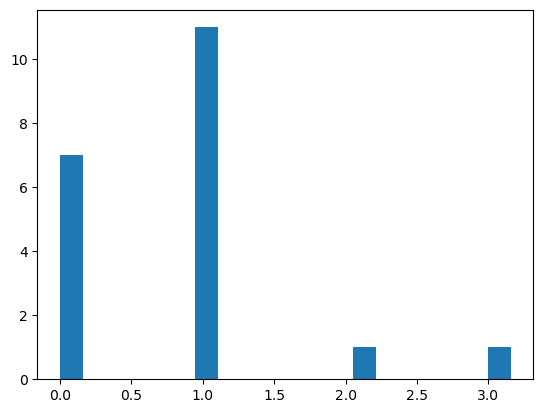

In [349]:
plt.hist(df_final['ap_psth'][0], bins=len(df_final['ap_psth'][0]))

In [351]:
len(df_final['ap_psth'][1])

20

In [ ]:
cols_to_drop = [
    # merge artifacts
    "index_x", "index_y", "level_0",

    # duplicate Vm stats
    "mean_vm_y", "std_vm_y",

    # label leakage
    "cell_type_x", "cell_type_y",

    # touch-related
    "touch_vm_change", "mean_vm_touch",
    "touch_slope_pre", "touch_slope_post",

    # spike-related
    "firing_rate", "ap_threshold", "ap_duration",
    #"ap_psth", #"ap_avg",

    "whisk_vm_change", #"wp_avg", "vm_avg"
]

df_clean = df_final.drop(columns=[c for c in cols_to_drop if c in df_merged.columns])


In [227]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cell_id                    86 non-null     object 
 1   mean_vm_x                  86 non-null     float64
 2   std_vm                     86 non-null     float64
 3   skew_vm                    86 non-null     float64
 4   kurt_vm                    86 non-null     float64
 5   low_power                  86 non-null     float64
 6   high_power                 86 non-null     float64
 7   spectral_entropy           86 non-null     float64
 8   dvm_std                    86 non-null     float64
 9   autocorr_decay             86 non-null     float64
 10  bump_rate                  86 non-null     float64
 11  mean_vm_quiet              86 non-null     float64
 12  mean_vm_whisk              86 non-null     float64
 13  whisk_slope_pre            86 non-null     float64
 

In [251]:
df_clean = df_clean.drop(columns=['wp_avg', 'vm_avg', 'ap_avg'])

In [252]:
corr = df_clean.drop(columns=["cell_id"]).corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.7)]
df_pruned = df_clean.drop(columns=to_drop)

In [253]:
df_pruned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 0 to 85
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   cell_id                   85 non-null     object 
 1   mean_vm_x                 85 non-null     float64
 2   std_vm                    85 non-null     float64
 3   skew_vm                   85 non-null     float64
 4   high_power                85 non-null     float64
 5   autocorr_decay            85 non-null     float64
 6   bump_rate                 85 non-null     float64
 7   whisk_slope_pre           85 non-null     float64
 8   whisk_slope_post          85 non-null     float64
 9   numb_events               85 non-null     int64  
 10  ap_fr_pre                 85 non-null     float64
 11  spectral_entropy_vm_post  85 non-null     float64
 12  lf_hf_ratio_vm_post       85 non-null     float64
 13  spectral_entropy_wp_post  85 non-null     float64
 14  dominant_freq_wp_

In [254]:
df_pruned = df_pruned.drop(columns=['mean_vm_x','std_vm','high_power','autocorr_decay','bump_rate','numb_events'])

In [255]:
df_pruned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 0 to 85
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   cell_id                   85 non-null     object 
 1   skew_vm                   85 non-null     float64
 2   whisk_slope_pre           85 non-null     float64
 3   whisk_slope_post          85 non-null     float64
 4   ap_fr_pre                 85 non-null     float64
 5   spectral_entropy_vm_post  85 non-null     float64
 6   lf_hf_ratio_vm_post       85 non-null     float64
 7   spectral_entropy_wp_post  85 non-null     float64
 8   dominant_freq_wp_post     85 non-null     float64
 9   whisk_motion_energy_post  85 non-null     float64
 10  spectral_entropy_ap_post  85 non-null     float64
 11  vm_ap_coupling_post       85 non-null     float64
 12  vm_wp_gain                85 non-null     float64
 13  vm_wp_r2                  85 non-null     float64
 14  coherence_vm_wp_4

In [100]:
data_df_subset_exc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, 6 to 627
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Cell_APThreshold_Slope                146 non-null    float64
 1   Cell_Anatomy                          146 non-null    object 
 2   Cell_Counter                          146 non-null    float64
 3   Cell_Depth                            146 non-null    float64
 4   Cell_ID                               146 non-null    object 
 5   Cell_Layer                            146 non-null    object 
 6   Cell_TargetedBrainArea                146 non-null    object 
 7   Cell_Type                             146 non-null    object 
 8   Cell_tdTomatoExpressing               146 non-null    object 
 9   Mouse_DateOfBirth                     89 non-null     float64
 10  Mouse_Genotype                        146 non-null    object 
 11  Mouse_Name              

In [256]:
dfa = data_df_subset_exc.groupby('Cell_ID').first().reset_index()

In [257]:
dfa

,Cell_ID,Cell_APThreshold_Slope,Cell_Anatomy,Cell_Counter,Cell_Depth,Cell_Layer,Cell_TargetedBrainArea,Cell_Type,Cell_tdTomatoExpressing,Mouse_DateOfBirth,...,Sweep_Counter,Sweep_MembranePotential,Sweep_MembranePotential_SamplingRate,Sweep_PassiveContactTimes,Sweep_QuietTimes,Sweep_StartTime,Sweep_Type,Sweep_WhiskerAngle,Sweep_WhiskerAngle_SamplingRate,Sweep_WhiskingTimes
0,JP902_1,10.0,L2/3;C1,1.0,348.0,L2/3,C2,EXC,False,NaN,...,1.0,"[-0.05913124978542328, -0.05911250039935112, -...",20000.0,nan,"[[0.002, 0.026], [1.27, 2.32], [3.326, 3.946],...",2009.0,free whisking,"[-0.25454164505004284, -0.39084636688232055, -...",100.0,"[[3.948, 4.052], [9.652, 19.986]]"
1,JP903_1,10.0,L2/3;C1,1.0,305.0,L2/3,C2,EXC,False,NaN,...,1.0,"[-0.06345625221729279, -0.0634625032544136, -0...",20000.0,nan,"[[0.002, 0.022], [4.218, 5.058], [5.82, 8.16],...",2009.0,free whisking,"[7.299275207519526, 7.180509185791015, 7.03050...",100.0,"[[1.828, 2.586], [8.17, 9.024], [10.22, 11.256..."
2,JP905_1,10.0,L2/3;septum,1.0,396.0,L2/3,C2,EXC,False,NaN,...,1.0,"[-0.055384375154972076, -0.05538124963641167, ...",20000.0,nan,"[[0.002, 0.024], [3.444, 3.986], [5.572, 6.162...",2008.0,free whisking,"[-0.06575365066528804, -0.48760803222656757, -...",100.0,"[[0.102, 0.902], [3.988, 4.726], [6.5, 7.488],..."
3,JP906_1,10.0,L2/3;C2,1.0,223.0,L2/3,C2,EXC,False,NaN,...,1.0,"[-0.05706875026226044, -0.05706249922513962, -...",20000.0,nan,"[[0.002, 0.03], [19.976, 20.0]]",2009.0,free whisking,"[0.5933248901367202, -1.0315834045410148, 0.12...",100.0,"[[0.042, 0.68], [1.134, 1.486], [1.904, 2.268]..."
4,JP907_1,10.0,L2/3;septum,1.0,197.0,L2/3,C2,EXC,False,NaN,...,1.0,"[-0.0599374994635582, -0.059950001537799835, -...",20000.0,nan,"[[0.002, 0.308], [15.636, 16.284], [17.718, 18...",2009.0,free whisking,"[-7.37948709487916, -6.377345962524421, -6.168...",100.0,"[[2.564, 3.322], [5.182, 10.442], [12.904, 14...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,TK538_1,20.0,L4;C2,1.0,391.0,L4,C2,EXC,True,2016.0,...,2.0,"[-0.07042035781732325, -0.07033814235989946, -...",20000.0,nan,"[[0.002, 18.948], [19.732, 42.542], [42.834, 5...",2017.0,free whisking,"[183.8954, 183.8954, 183.8954, 184.1821, 183.8...",100.0,"[[18.994, 19.656], [42.544, 42.83], [53.578, 5..."
82,TK539_1,15.0,L4;C3,1.0,380.0,L4,C2,EXC,True,2017.0,...,2.0,"[-0.059143708543635085, -0.059156862964613616,...",20000.0,nan,"[[0.002, 0.224], [0.35, 1.49], [3.662, 5.412],...",2017.0,free whisking,"[193.5242, 193.2379, 192.9517, 192.9517, 192.9...",100.0,"[[0.226, 0.348], [1.492, 3.566], [5.414, 6.054..."
83,TK539_2,15.0,L4;C3,2.0,460.0,L4,C2,EXC,True,2017.0,...,3.0,"[-0.05660161773836156, -0.056572020315506476, ...",20000.0,nan,"[[0.002, 17.686], [17.954, 18.728], [18.814, 4...",2017.0,free whisking,"[193.2379, 193.5242, 193.5242, 192.6655, 192.6...",100.0,"[[17.7, 17.922], [45.296, 45.584], [49.372, 50..."
84,TK545_1,10.0,L4;septum,1.0,432.0,L4,C2,EXC,True,2016.0,...,2.0,"[-0.05555584229724142, -0.055516379079719666, ...",20000.0,nan,"[[0.002, 0.022], [1.352, 3.306], [3.782, 4.682...",2017.0,free whisking,"[185.7961, 185.5098, 185.5098, 188.0859, 194.3...",100.0,"[[0.026, 1.35], [4.894, 5.442], [6.536, 8.272]..."


In [259]:
data_df_subset_exc['Cell_ID'][49]

'SC911_1'

In [111]:
data_df_subset_exc[data_df_subset_exc['Cell_ID'] == 'SC904_1']

,Cell_APThreshold_Slope,Cell_Anatomy,Cell_Counter,Cell_Depth,Cell_ID,Cell_Layer,Cell_TargetedBrainArea,Cell_Type,Cell_tdTomatoExpressing,Mouse_DateOfBirth,...,Sweep_Counter,Sweep_MembranePotential,Sweep_MembranePotential_SamplingRate,Sweep_PassiveContactTimes,Sweep_QuietTimes,Sweep_StartTime,Sweep_Type,Sweep_WhiskerAngle,Sweep_WhiskerAngle_SamplingRate,Sweep_WhiskingTimes
13,10.0,L2/3;septum,1.0,244.0,SC904_1,L2/3,C2,EXC,False,NaN,...,3.0,"[-0.045740625, -0.04585, -0.045846875, -0.0458...",20000.0,nan,"[[0.002, 0.056], [0.802, 2.152], [3.59, 4.138]...",2005.0,free whisking,"[-4.778280115256763, -4.52540728696988, -4.253...",100.0,"[[2.94, 3.338], [4.142, 4.42], [5.66, 7.786], ..."
16,10.0,L2/3;septum,1.0,244.0,SC904_1,L2/3,C2,EXC,False,NaN,...,6.0,"[-0.045790625, -0.045784374999999995, -0.04580...",20000.0,nan,"[[0.002, 0.802], [0.894, 1.612], [2.816, 3.382...",2005.0,free whisking,"[4.4652514485863435, 4.393040669386693, 3.6848...",100.0,"[[1.63, 2.214], [4.732, 5.646], [8.218, 10.066..."


In [120]:
dfa.index

Index(['JP902_1', 'JP903_1', 'JP905_1', 'JP906_1', 'JP907_1', 'SC901_1',
       'SC902_1', 'SC904_1', 'SC905_1', 'SC906_1', 'SC908_1', 'SC910_1',
       'SC911_1', 'SC912_1', 'SC916_1', 'SC917_1', 'SC918_1', 'SC919_1',
       'SC923_1', 'SC924_1', 'SC925_1', 'SC926_1', 'TK140_1', 'TK140_2',
       'TK146_1', 'TK181_1', 'TK184_1', 'TK236_1', 'TK241_2', 'TK250_2',
       'TK254_2', 'TK266_1', 'TK272_1', 'TK276_1', 'TK277_1', 'TK278_1',
       'TK283_2', 'TK299_1', 'TK304_1', 'TK316_1', 'TK318_1', 'TK355_2',
       'TK355_3', 'TK383_1', 'TK385_1', 'TK385_2', 'TK387_1', 'TK402_1',
       'TK403_1', 'TK408_1', 'TK409_1', 'TK413_1', 'TK414_1', 'TK415_1',
       'TK415_2', 'TK415_3', 'TK416_1', 'TK455_1', 'TK457_1', 'TK460_2',
       'TK462_1', 'TK470_1', 'TK473_1', 'TK485_1', 'TK485_2', 'TK490_1',
       'TK496_1', 'TK496_2', 'TK496_3', 'TK496_4', 'TK497_1', 'TK497_2',
       'TK497_3', 'TK498_1', 'TK499_1', 'TK499_2', 'TK499_3', 'TK504_1',
       'TK504_2', 'TK509_1', 'TK532_1', 'TK538_1', 

In [260]:
df_pruned["cell_layer"] = df_pruned["cell_id"].map(
    dfa.set_index("Cell_ID")["Cell_Layer"]
)

In [362]:
#X = df_pruned.drop(columns=["cell_id", "cell_layer"])
y = df_pruned["cell_layer"]
y = y.map({'L2/3': 0, 'L4': 1, 'L5': 2})

In [363]:
y

0     0
1     0
2     0
3     0
4     0
     ..
81    1
82    1
83    1
84    1
85    1
Name: cell_layer, Length: 85, dtype: int64

In [190]:
X = X.fillna(X.mean())

In [169]:
fr_mean = df_pruned["ap_fr_pre"].mean()
df_pruned["ap_fr_pre"].fillna(fr_mean, inplace=True)

C:\Users\Utente\AppData\Local\Temp\ipykernel_11380\3474553496.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pruned["ap_fr_pre"].fillna(fr_mean, inplace=True)


## Logistic regression

Now we can train a logistic regression on this!!

In [283]:
df_final = df_final.drop([49])

In [308]:
from scipy.stats import skew

X_final["skew_vm_avg"] = df_final["vm_avg"].apply(
    lambda x: skew(x, nan_policy="omit")
)

X_final = X_final.drop(columns=['skew_vm_avg'])

In [318]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.inspection import permutation_importance

clf = LogisticRegression(
    solver="lbfgs",
    max_iter=100000
)

clf.fit(X_final, y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100000
,multi_class,'deprecated'


In [297]:
X_final.columns

Index(['whisk_motion_energy_post', 'skew_vm', 'lf_hf_ratio_vm_post',
       'spectral_entropy_vm_post', 'ap_fr_pre', 'dominant_freq_wp_post'],
      dtype='object')

In [319]:
coef = clf.coef_

coef_df = pd.DataFrame(
    coef,
    columns=X_final.columns,
    index=[f"class_{c}" for c in ['L2/3','L4','L5']] if coef.shape[0] > 1 else ["layer_effect"]
)
coef_df

,whisk_motion_energy_post,skew_vm,lf_hf_ratio_vm_post,spectral_entropy_vm_post,ap_fr_pre,dominant_freq_wp_post
class_L2/3,-9.891504e-07,-0.976896,0.061994,1.390712,-0.045795,-0.012652
class_L4,1.844822e-06,0.442475,-0.127594,-0.900777,-0.197047,0.010095
class_L5,-8.556295e-07,0.534425,0.065601,-0.489921,0.242845,0.002557


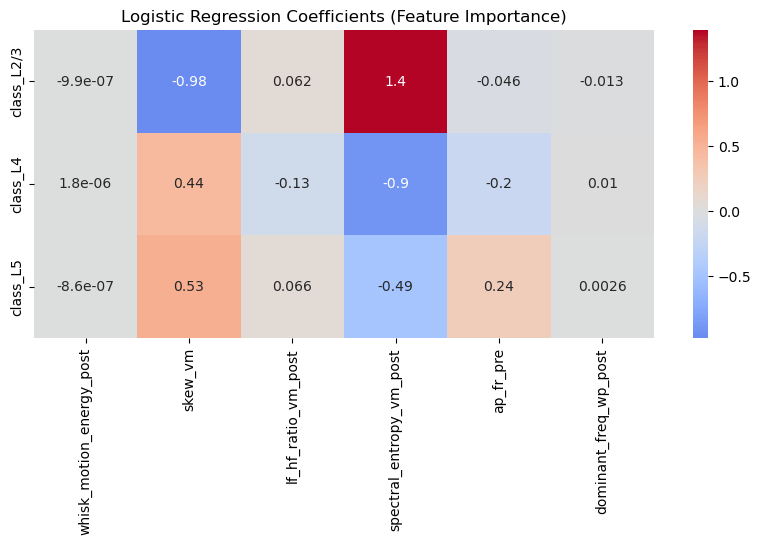

In [320]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
sns.heatmap(coef_df, cmap="coolwarm", center=0, annot=True)
plt.title("Logistic Regression Coefficients (Feature Importance)")
plt.show()


In [321]:
perm = permutation_importance(
    clf,
    X_final,
    y,
    scoring="accuracy",
    n_repeats=50,
    random_state=42
)
feature_cols = df_pruned.drop(columns=["cell_id", "cell_layer"]).columns
perm_df = pd.DataFrame({
    "feature": X_final.columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

perm_df

,feature,importance_mean,importance_std
0,whisk_motion_energy_post,0.167294,0.045885
1,skew_vm,0.150588,0.036527
2,lf_hf_ratio_vm_post,0.110824,0.037874
3,spectral_entropy_vm_post,0.081882,0.030037
4,ap_fr_pre,0.024706,0.025150
5,dominant_freq_wp_post,0.009647,0.014824


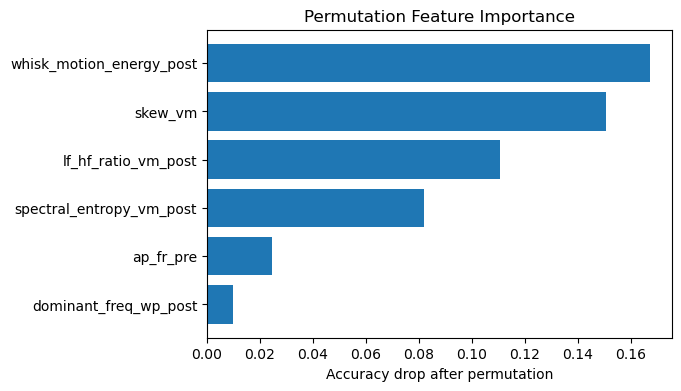

In [322]:
plt.figure(figsize=(6,4))
plt.barh(perm_df["feature"], perm_df["importance_mean"])
plt.gca().invert_yaxis()
plt.xlabel("Accuracy drop after permutation")
plt.title("Permutation Feature Importance")
plt.show()


What if we fit a model just with the two strongest features? **spectral entropy post vm++ and **vm's general skewness++ ?

In [323]:
X_reduced = X_final[['skew_vm', 'spectral_entropy_vm_post']]

clf2 = LogisticRegression(
    solver="lbfgs",
    max_iter=100000
)

clf2.fit(X_reduced, y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100000
,multi_class,'deprecated'


In [324]:
coef2 = clf2.coef_

coef_df2 = pd.DataFrame(
    coef2,
    columns=X_reduced.columns,
    index=[f"class_{c}" for c in ['L2/3','L4','L5']] if coef.shape[0] > 1 else ["layer_effect"]
)
coef_df2

,skew_vm,spectral_entropy_vm_post
class_L2/3,-1.165570,0.439003
class_L4,0.432397,0.126797
class_L5,0.733173,-0.565800


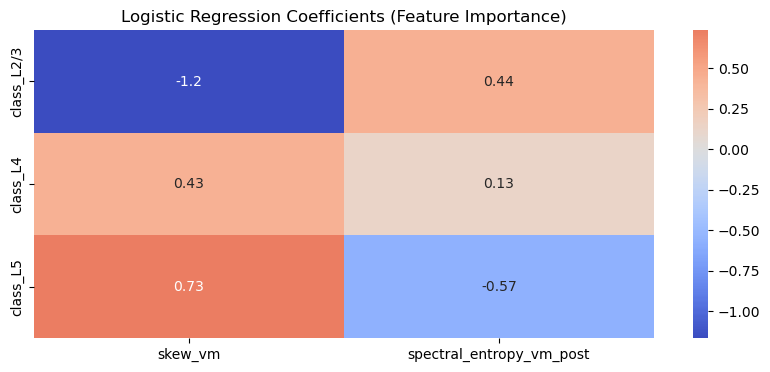

In [325]:
plt.figure(figsize=(10,4))
sns.heatmap(coef_df2, cmap="coolwarm", center=0, annot=True)
plt.title("Logistic Regression Coefficients (Feature Importance)")
plt.show()

In [326]:
pipe = Pipeline([
    #("scaler", RobustScaler()),
    ("clf2", LogisticRegression(
        solver="lbfgs",
        max_iter=100000,
        C=0.5,
        class_weight="balanced"
    ))
])

loo = LeaveOneOut()

scores = cross_val_score(
    pipe,            # or clf if no pipeline
    X_reduced,
    y,
    cv=loo,
    scoring="accuracy"
)

print(
    f"LOOCV accuracy: {scores.mean():.3f} ± {scores.std():.3f}"
)

LOOCV accuracy: 0.565 ± 0.496


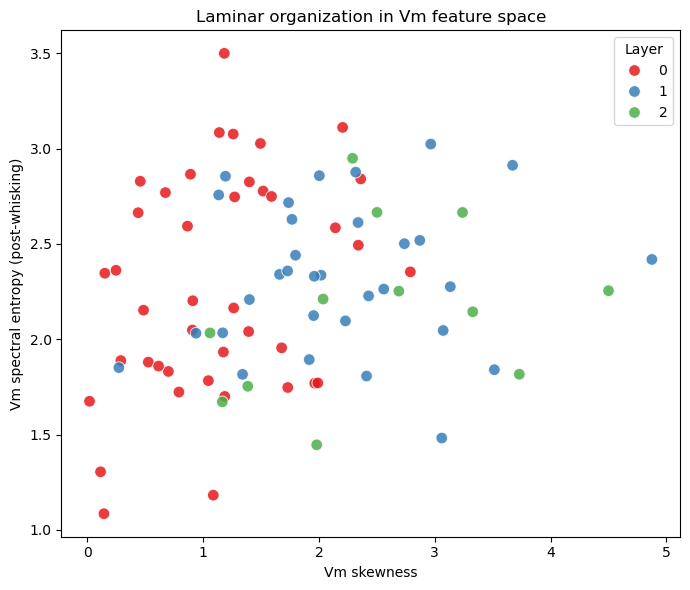

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Build plotting dataframe
plot_df = pd.DataFrame({
    "skew_vm": X_reduced["skew_vm"],
    "spectral_entropy_vm_post": X_reduced["spectral_entropy_vm_post"],
    "layer": y
})

plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=plot_df,
    x="skew_vm",
    y="spectral_entropy_vm_post",
    hue="layer",
    palette="Set1",
    s=70,
    alpha=0.85
)

plt.xlabel("Vm skewness")
plt.ylabel("Vm spectral entropy (post-whisking)")
plt.title("Laminar organization in Vm feature space")
plt.legend(title="Layer")
plt.tight_layout()
plt.show()


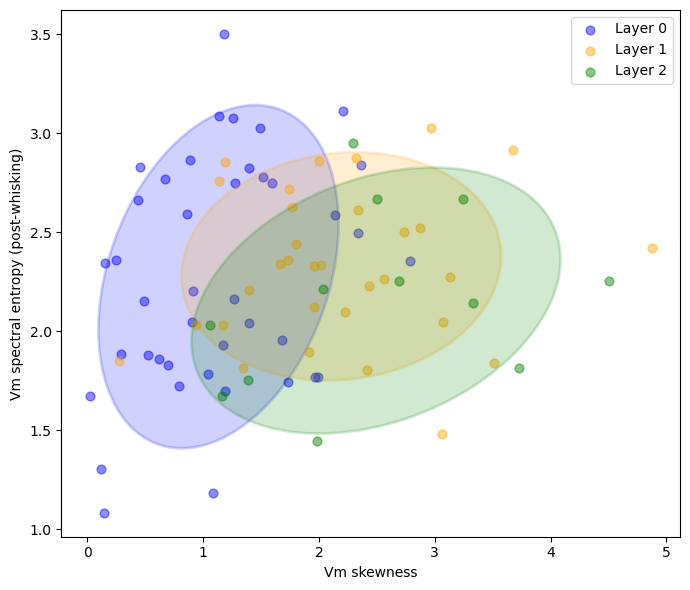

In [331]:
import numpy as np
from matplotlib.patches import Ellipse

def plot_cov_ellipse(mean, cov, ax, n_std=1.5, color="k", alpha=0.15, lw=2):
    from matplotlib.patches import Ellipse
    import numpy as np

    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)

    ellipse = Ellipse(
        mean,
        width,
        height,
        angle=angle,
        edgecolor=color,
        facecolor=color,
        alpha=alpha,
        lw=lw
    )
    ax.add_patch(ellipse)


fig, ax = plt.subplots(figsize=(7,6))

colors = {0: "blue", 1: "orange", 2: "green"}

for layer in np.unique(y):
    pts = plot_df[plot_df["layer"] == layer][["skew_vm","spectral_entropy_vm_post"]].values

    ax.scatter(
        pts[:,0], pts[:,1],
        alpha=0.45, s=40, color=colors[layer], label=f"Layer {layer}"
    )

    plot_cov_ellipse(
        pts.mean(axis=0),
        np.cov(pts.T),
        ax,
        color=colors[layer],
        alpha=0.18,
        n_std=1.5
    )

ax.set_xlabel("Vm skewness")
ax.set_ylabel("Vm spectral entropy (post-whisking)")
ax.legend()
plt.tight_layout()
plt.show()



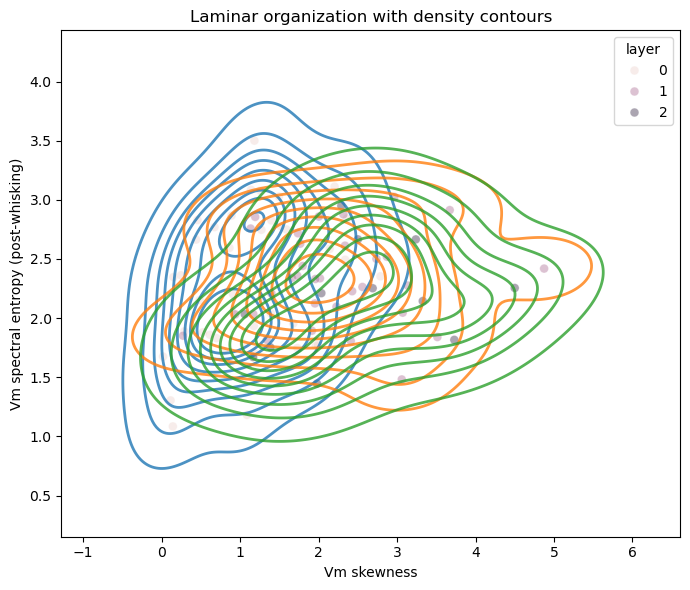

In [334]:
import seaborn as sns

plt.figure(figsize=(7,6))

for layer in np.unique(y):
    subset = plot_df[plot_df["layer"] == layer]
    sns.kdeplot(
        x=subset["skew_vm"],
        y=subset["spectral_entropy_vm_post"],
        levels=10,
        linewidths=2,
        alpha=0.8,
        label=f"Layer {layer}"
    )

sns.scatterplot(
    data=plot_df,
    x="skew_vm",
    y="spectral_entropy_vm_post",
    hue="layer",
    alpha=0.4,
    s=40
)

plt.xlabel("Vm skewness")
plt.ylabel("Vm spectral entropy (post-whisking)")
plt.title("Laminar organization with density contours")
plt.tight_layout()
plt.show()


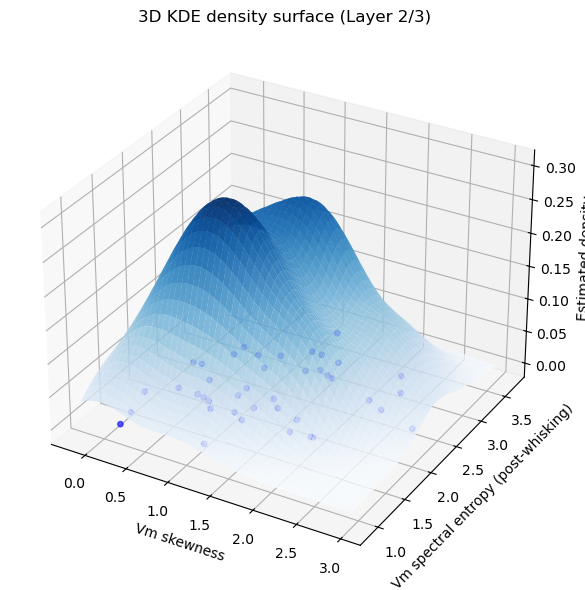

In [339]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# select one layer
layer_id = 0  # e.g. L2/3
subset = plot_df[plot_df["layer"] == layer_id]

x = subset["skew_vm"].values
y = subset["spectral_entropy_vm_post"].values

# grid
xgrid = np.linspace(x.min() - 0.2, x.max() + 0.2, 100)
ygrid = np.linspace(y.min() - 0.2, y.max() + 0.2, 100)
X, Y = np.meshgrid(xgrid, ygrid)

# KDE
kde = gaussian_kde(np.vstack([x, y]))
Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

# plot
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(
    X, Y, Z,
    cmap="Blues",
    linewidth=0,
    alpha=0.85
)
ax.scatter(
    x, y,
    np.zeros_like(x),
    color="blue",
    s=15,
    alpha=0.6
)

ax.set_xlabel("Vm skewness")
ax.set_ylabel("Vm spectral entropy (post-whisking)")
ax.set_zlabel("Estimated density")
ax.set_title("3D KDE density surface (Layer 2/3)")

plt.tight_layout()
plt.show()
        

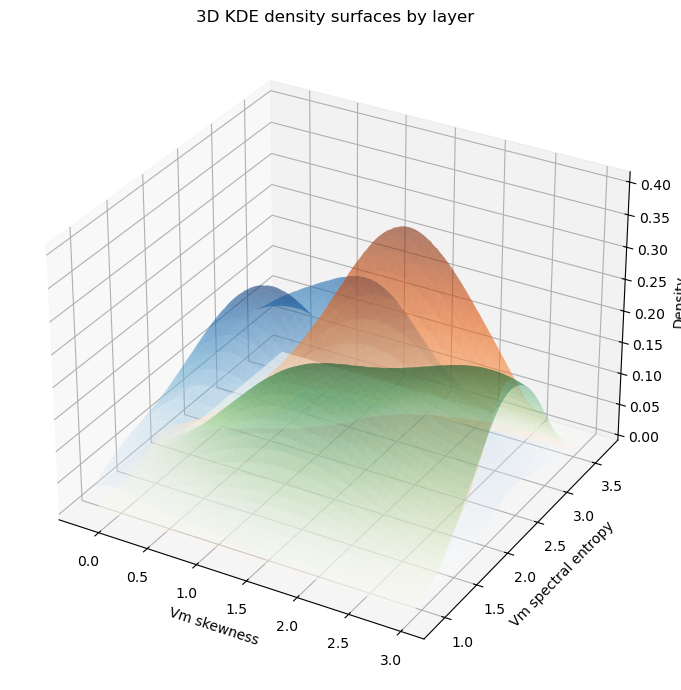

In [340]:
colors = {0: "Blues", 1: "Oranges", 2: "Greens"}

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection="3d")

for layer_id in np.unique(plot_df["layer"]):
    subset = plot_df[plot_df["layer"] == layer_id]
    x = subset["skew_vm"].values
    y = subset["spectral_entropy_vm_post"].values
    
    kde = gaussian_kde(np.vstack([x, y]))
    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)
    
    ax.plot_surface(
        X, Y, Z,
        cmap=colors[layer_id],
        alpha=0.35,
        linewidth=0
    )

ax.set_xlabel("Vm skewness")
ax.set_ylabel("Vm spectral entropy")
ax.set_zlabel("Density")
ax.set_title("3D KDE density surfaces by layer")

plt.tight_layout()
plt.show()


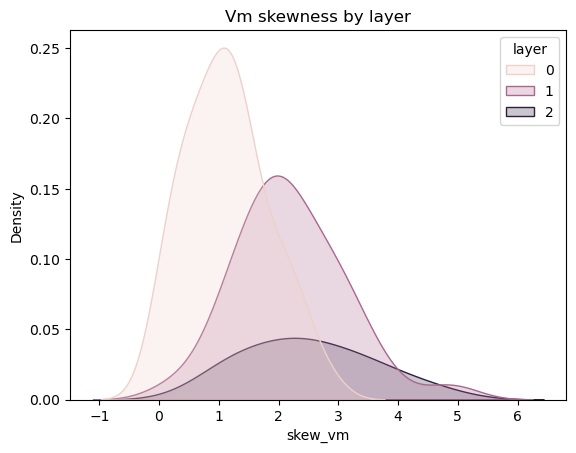

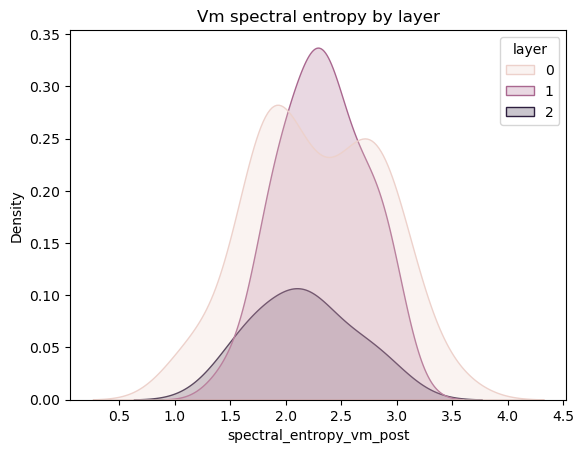

In [329]:
import seaborn as sns

sns.kdeplot(data=plot_df, x="skew_vm", hue="layer", fill=True)
plt.title("Vm skewness by layer")
plt.show()

sns.kdeplot(data=plot_df, x="spectral_entropy_vm_post", hue="layer", fill=True)
plt.title("Vm spectral entropy by layer")
plt.show()


In [268]:
final_features = [
    "whisk_motion_energy_post",
    "skew_vm",
    "lf_hf_ratio_vm_post",
    "spectral_entropy_vm_post",
    "ap_fr_pre",
    "dominant_freq_wp_post"
]

X_final = X[final_features].copy()

X_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 0 to 85
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   whisk_motion_energy_post  85 non-null     float64
 1   skew_vm                   85 non-null     float64
 2   lf_hf_ratio_vm_post       85 non-null     float64
 3   spectral_entropy_vm_post  85 non-null     float64
 4   ap_fr_pre                 85 non-null     float64
 5   dominant_freq_wp_post     85 non-null     float64
dtypes: float64(6)
memory usage: 4.6 KB


In [141]:
X.values

array([[-5.56290968e-02,  4.36474008e-03,  2.20416040e+00,
         2.02697649e-08,  8.46571429e+02,  0.00000000e+00,
        -1.82321774e-02,  4.58125025e-02,  1.90000000e+01],
       [-6.68977535e-02,  4.40251224e-03,  1.17442450e+00,
         5.11916591e-09,  1.09250000e+03,  0.00000000e+00,
         2.74714145e-02, -9.09218565e-02,  1.40000000e+01],
       [-5.61978909e-02,  4.15007994e-03,  1.67737026e+00,
         1.67397532e-08,  1.04380000e+03,  0.00000000e+00,
         3.41124982e-02, -9.66625065e-02,  1.70000000e+01],
       [-5.58412615e-02,  4.52064170e-03,  4.84698327e-01,
         9.89518381e-09,  1.03555556e+03,  0.00000000e+00,
        -4.89907047e-02, -3.53046786e-02,  2.80000000e+01],
       [-5.55302506e-02,  2.61832632e-03,  2.46733027e-01,
         1.61768967e-09,  1.31075000e+03,  0.00000000e+00,
        -1.32187642e-02,  7.04687089e-03,  1.40000000e+01],
       [-3.83484253e-02,  5.26132893e-03,  4.38622176e-01,
         1.03867434e-08,  1.21670000e+04,  0.000000

In [142]:
B = 300
boot_coefs = []

for _ in range(B):
    idx = np.random.choice(len(X), len(X), replace=True)
    clf.fit(X.values[idx], y[idx])
    boot_coefs.append(clf.coef_)

boot_coefs = np.array(boot_coefs)


In [149]:
print(len(feature_cols))

9


In [143]:
lower = np.percentile(boot_coefs, 2.5, axis=0)
upper = np.percentile(boot_coefs, 97.5, axis=0)

ci_df = pd.DataFrame({
    "feature": feature_cols,
    "coef_mean": coef.flatten(),
    "ci_low": lower.flatten(),
    "ci_high": upper.flatten()
})

ci_df["stable"] = ~((ci_df["ci_low"] < 0) & (ci_df["ci_high"] > 0))
ci_df.sort_values("stable", ascending=False)

ValueError: All arrays must be of the same length

In [269]:
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    #("scaler", RobustScaler()),
    ("clf", LogisticRegression(
        solver="lbfgs",
        max_iter=100000,
        C=0.5,
        class_weight="balanced"
    ))
])

loo = LeaveOneOut()

scores = cross_val_score(
    pipe,            # or clf if no pipeline
    X,
    y,
    cv=loo,
    scoring="accuracy"
)

print(
    f"LOOCV accuracy: {scores.mean():.3f} ± {scores.std():.3f}"
)


c:\Users\Utente\anaconda3\envs\bio482\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 13393 iteration(s) (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Utente\anaconda3\envs\bio482\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 13404 iteration(s) (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

LOOCV accuracy: 0.612 ± 0.487


c:\Users\Utente\anaconda3\envs\bio482\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 13364 iteration(s) (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [366]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
import numpy as np

def loocv_accuracy(X, y, model):
    loo = LeaveOneOut()
    preds = []
    trues = []

    for train_idx, test_idx in loo.split(X):
        model.fit(X[train_idx], y[train_idx])
        preds.append(model.predict(X[test_idx])[0])
        trues.append(y[test_idx][0])

    return accuracy_score(trues, preds)

clff = LogisticRegression(
    solver="lbfgs",
    max_iter=100000,
    C=0.5,
    class_weight="balanced"
) 

# observed accuracy
obs_acc = loocv_accuracy(X_final.values, y.values, clff)

# permutation distribution
n_perm = 100
perm_acc = []

for _ in range(n_perm):
    y_perm = np.random.permutation(y.values)
    perm_acc.append(loocv_accuracy(X_final.values, y_perm, clff))

perm_acc = np.array(perm_acc)

p_value = np.mean(perm_acc >= obs_acc)

print("Observed LOOCV accuracy:", obs_acc)
print("Permutation p-value:", p_value)


c:\Users\Utente\anaconda3\envs\bio482\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 13440 iteration(s) (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Utente\anaconda3\envs\bio482\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 13370 iteration(s) (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

Observed LOOCV accuracy: 0.6705882352941176
Permutation p-value: 0.0


In [ ]:
p_value = np.mean(perm_acc >= obs_acc, )

In [ ]:
p_value = (np.sum(perm_acc >= obs_acc) + 1) / (len(perm_acc) + 1)
print(f"Permutation p-value: {p_value:.6f}")

0     2
1     2
2     2
3     2
4     2
     ..
81    3
82    3
83    3
84    3
85    3
Name: cell_layer, Length: 86, dtype: int64

## New features

In [212]:
from scipy.signal import coherence

def extract_advanced_event_features(
    df,
    vm_col="vm_avg",
    wp_col="wp_avg",
    ap_col="ap_avg",
    fs_vm=20000,
    fs_wp=500
):
    features = []

    for _, row in df.iterrows():

        vm = np.asarray(row[vm_col])
        wp = np.asarray(row[wp_col])
        ap = np.asarray(row[ap_col])

        # --- split pre / post (event at midpoint)
        mid_vm = len(vm) // 2
        mid_wp = len(wp) // 2
        mid_ap = len(ap) // 2

        vm_pre, vm_post = vm[:mid_vm], vm[mid_vm:]
        wp_post = wp[mid_wp:]
        ap_post = ap[mid_ap:]

        # ensure equal lengths
        L = min(len(vm_post), len(wp_post), len(ap_post))
        vm_post, wp_post, ap_post = vm_post[:L], wp_post[:L], ap_post[:L]

        # --------------------------------------------------
        # 1) Vm–whisker linear encoding (gain + R²)
        # --------------------------------------------------
        lr = LinearRegression()
        lr.fit(wp_post.reshape(-1, 1), vm_post)
        vm_wp_gain = lr.coef_[0]
        vm_wp_r2 = lr.score(wp_post.reshape(-1, 1), vm_post)

        # --------------------------------------------------
        # 2) Vm–whisker coherence (4–20 Hz)
        # --------------------------------------------------
        f, coh = coherence(vm_post, wp_post, fs=fs_vm, nperseg=len(vm_post))
        band = (f >= 4) & (f <= 20)
        coherence_vm_wp = np.mean(coh[band]) if np.any(band) else 0.0

        # --------------------------------------------------
        # 3) Temporal centroid of Vm response
        # --------------------------------------------------
        baseline = vm_pre.mean()
        resp = np.abs(vm_post - baseline)
        t = np.linspace(0, 1, len(resp))
        temporal_centroid = np.sum(t * resp) / (np.sum(resp) + 1e-12)

        # --------------------------------------------------
        # 4) Response duration above baseline
        # --------------------------------------------------
        thr = baseline + 0.5 * vm_pre.std()
        response_duration = np.mean(vm_post > thr)

        # --------------------------------------------------
        # 5) AR(1) coefficient of Vm_post
        # --------------------------------------------------
        vm_post_demean = vm_post - vm_post.mean()
        ar1 = np.corrcoef(vm_post_demean[:-1], vm_post_demean[1:])[0, 1]

        # --------------------------------------------------
        # 6) Vm → AP gain
        # --------------------------------------------------
        if np.std(vm_post) > 0:
            vm_ap_gain = np.mean(ap_post) / (np.std(vm_post) + 1e-12)
        else:
            vm_ap_gain = 0.0

        features.append({
            "vm_wp_gain": vm_wp_gain,
            "vm_wp_r2": vm_wp_r2,
            "coherence_vm_wp_4_20": coherence_vm_wp,
            "temporal_centroid_vm_post": temporal_centroid,
            "response_duration_vm": response_duration,
            "ar1_vm_post": ar1,
            "vm_ap_gain": vm_ap_gain
        })

    return pd.DataFrame(features, index=df.index)

In [235]:
# Select only numeric columns
num_cols = df_clean.select_dtypes(include=[np.number]).columns

# Fill NaNs with column-wise mean
df_clean[num_cols] = df_clean[num_cols].apply(
    lambda x: x.fillna(x.mean())
)

In [237]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cell_id                    86 non-null     object 
 1   mean_vm_x                  86 non-null     float64
 2   std_vm                     86 non-null     float64
 3   skew_vm                    86 non-null     float64
 4   kurt_vm                    86 non-null     float64
 5   low_power                  86 non-null     float64
 6   high_power                 86 non-null     float64
 7   spectral_entropy           86 non-null     float64
 8   dvm_std                    86 non-null     float64
 9   autocorr_decay             86 non-null     float64
 10  bump_rate                  86 non-null     float64
 11  mean_vm_quiet              86 non-null     float64
 12  mean_vm_whisk              86 non-null     float64
 13  whisk_slope_pre            86 non-null     float64
 

In [246]:
df_clean = df_clean.drop([49])
advanced_features = extract_advanced_event_features(df_clean)

df_clean = pd.concat([df_clean, advanced_features], axis=1)

In [248]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, 0 to 85
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   cell_id                    85 non-null     object 
 1   mean_vm_x                  85 non-null     float64
 2   std_vm                     85 non-null     float64
 3   skew_vm                    85 non-null     float64
 4   kurt_vm                    85 non-null     float64
 5   low_power                  85 non-null     float64
 6   high_power                 85 non-null     float64
 7   spectral_entropy           85 non-null     float64
 8   dvm_std                    85 non-null     float64
 9   autocorr_decay             85 non-null     float64
 10  bump_rate                  85 non-null     float64
 11  mean_vm_quiet              85 non-null     float64
 12  mean_vm_whisk              85 non-null     float64
 13  whisk_slope_pre            85 non-null     float64
 14  w

In [ ]:
import numpy as np

array_cols = ["vm_avg", "wp_avg", "ap_avg"]

for col in array_cols:
    n_cells_with_nan = df_clean[col].apply(
        lambda x: np.isnan(x).any() if isinstance(x, np.ndarray) else False
    ).sum()
    print(f"{col}: {n_cells_with_nan} cells contain NaNs")


vm_avg: 1 cells contain NaNs
wp_avg: 1 cells contain NaNs
ap_avg: 1 cells contain NaNs


In [239]:
for col in array_cols:
    total_nans = df_clean[col].apply(
        lambda x: np.isnan(x).sum() if isinstance(x, np.ndarray) else 0
    ).sum()
    
    print(f"{col}: {total_nans} total NaN values")


vm_avg: 20000 total NaN values
wp_avg: 100 total NaN values
ap_avg: 20000 total NaN values


In [240]:
import numpy as np

array_cols = ["vm_avg", "wp_avg", "ap_avg"]

for col in array_cols:
    idx_with_nan = df_clean.index[
        df_clean[col].apply(lambda x: np.isnan(x).any())
    ].tolist()
    
    print(f"{col}: {len(idx_with_nan)} rows with NaNs")
    print(idx_with_nan[:10], "...\n")  # show first few

vm_avg: 1 rows with NaNs
[49] ...

wp_avg: 1 rows with NaNs
[49] ...

ap_avg: 1 rows with NaNs
[49] ...



In [245]:
df_clean[49:50]['vm_avg']

49    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
Name: vm_avg, dtype: object